Trabalho 

In [2]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prep2 import DataPreparation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

In [3]:
prep = DataPreparation()

train_db = pd.read_csv("dataset/train_radiomics_hipocamp.csv")
test_db = pd.read_csv("dataset/test_radiomics_hipocamp.csv")
control_db = pd.read_csv("dataset/train_radiomics_occipital_CONTROL.csv")

train_db = prep.prep_train(train_db)
test_db = prep.transform(test_db)
control_db = prep.transform(control_db)

In [4]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 689 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(688), object(1)
memory usage: 1.6+ MB


In [5]:
test_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 688 entries, diagnostics_Image-original_Mean to Age
dtypes: float64(688)
memory usage: 537.6 KB


In [6]:
X = train_db.drop(columns=["Transition"]) 
y = train_db["Transition"]  

In [7]:
X_train = pd.read_csv('prep2/train_X.csv')
X_test = pd.read_csv('prep2/test_X.csv')
y_train = pd.read_csv('prep2/train_y.csv')
y_test = pd.read_csv('prep2/test_y.csv')

In [8]:
clf = GradientBoostingClassifier(random_state=2024)

param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_leaf': [5],
    'min_samples_split': [5],
}

cv_strategy = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='f1_macro',  
    cv=cv_strategy,        
    verbose=1,              
    refit=True,
    n_jobs=-1 
)

grid_search.fit(X, y)

print("Melhores parâmetros encontrados:", grid_search.best_params_)

best_model = grid_search.best_estimator_

print("F1 Score médio com validação cruzada:", grid_search.best_score_)

from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(best_model, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")


print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Melhores parâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150}
F1 Score médio com validação cruzada: 0.3880247127694698

Relatório de Classificação:


NameError: name 'y_pred_class' is not defined

F1-Score no conjunto de controle: 0.18785575743912636


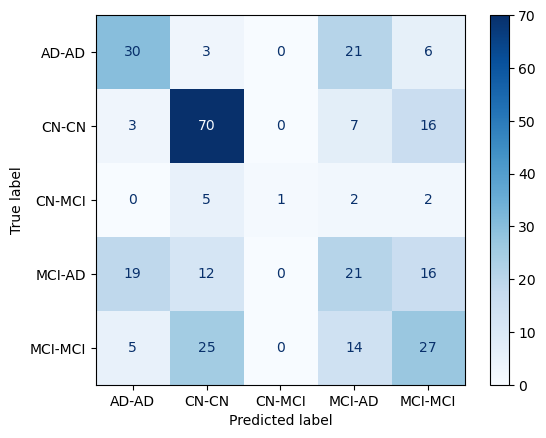

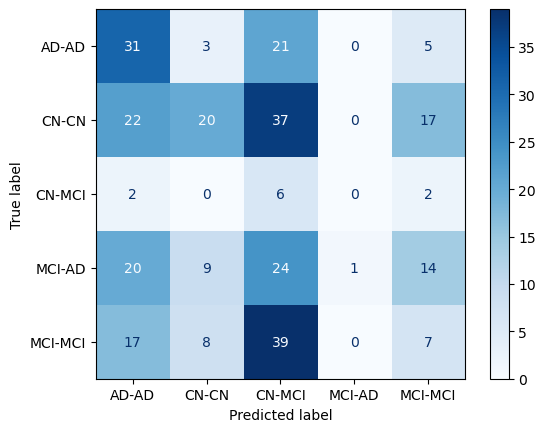


Relatório de Classificação no conjunto de controle:
              precision    recall  f1-score   support

       AD-AD       0.34      0.52      0.41        60
       CN-CN       0.50      0.21      0.29        96
      CN-MCI       0.05      0.60      0.09        10
      MCI-AD       1.00      0.01      0.03        68
     MCI-MCI       0.16      0.10      0.12        71

    accuracy                           0.21       305
   macro avg       0.41      0.29      0.19       305
weighted avg       0.48      0.21      0.21       305



In [9]:
CX = control_db.drop(columns=["Transition"]) 
Cy = control_db["Transition"]  

control_pred = best_model.predict(CX)

control_f1_score = f1_score(Cy, control_pred, average='macro')
print("F1-Score no conjunto de controle:", control_f1_score)

# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(Cy, control_pred, cmap='Blues')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação no conjunto de controle:")
print(classification_report(Cy, control_pred))

In [ ]:
best_model.fit(X, y)
test_predictions = best_model.predict(test_db)

row_ids = range(1, len(test_predictions) + 1)

output_df = pd.DataFrame({
    "RowId": row_ids,
    "Result": test_predictions
})


output_df.to_csv("resultados/gb2.csv", index=False)